# Imports

In [25]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk

path = '../src/'
sys.path.append(path)

from utils_ldms import *

# Read the data

Data available here:
https://www.kaggle.com/datasets/narsil/jobs-in-data-com

First download and save it into "data" folder.

In [2]:
df = pd.read_csv('../data/job_descriptions.csv')

# Feature Engineering and EDA

In [3]:
df['experience_list'] = df["Experience"].apply(lambda x: [
    float(i.strip()) for i in x.replace('Years', '').split('to')
    ])

In [4]:
df['min_experience'] = df['experience_list'].apply(lambda x: x[0])

In [5]:
df['min_experience'].value_counts()

min_experience
5.0    269965
3.0    269767
1.0    269681
4.0    269083
2.0    268816
0.0    268628
Name: count, dtype: int64

In [6]:
df['Role'].value_counts()

Role
Interaction Designer            20580
Network Administrator           17470
User Interface Designer         14036
Social Media Manager            13945
User Experience Designer        13935
                                ...  
Inventory Control Specialist     3342
Budget Analyst                   3335
Clinical Nurse Manager           3324
Social Science Researcher        3321
Paid Advertising Specialist      3306
Name: count, Length: 376, dtype: int64

In [7]:
df['Work Type'].value_counts()

Work Type
Part-Time    324044
Temporary    323439
Contract     323131
Intern       323090
Full-Time    322236
Name: count, dtype: int64

In [8]:
df = df[df['Country']=='USA']
#df = df[df['Work Type']=='Full Time']
#df = df[df['min_experience'].apply(lambda x: x<1.0)]

## Data Cleaning / Preparation

In [9]:
#clean text applying all the text preprocessing functions
df['cleaned_text'] = df['Job Description'].apply(
    lambda x: ' '.join(preprocess_text(x))
    )
df.head()

,Job Id,Experience,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,...,Job Portal,Job Description,Benefits,skills,Responsibilities,Company,Company Profile,experience_list,min_experience,cleaned_text
156,579575048679091,3 to 9 Years,MCA,$59K-$117K,"Washington, D.C.",USA,37.0902,-95.7129,Temporary,126334,...,USAJOBS,"Wireless Network Engineers design, implement, ...","{'Flexible Spending Accounts (FSAs), Relocatio...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Lendlease Group,"{""Sector"":""Real Estate/Construction"",""Industry...","[3.0, 9.0]",3.0,wireless network engineer design implement mai...
270,288941837754490,4 to 15 Years,B.Tech,$57K-$117K,"Washington, D.C.",USA,37.0902,-95.7129,Intern,35869,...,The Muse,Develop and implement urban planning strategie...,"{'Employee Referral Programs, Financial Counse...",Urban design and planning Zoning regulations G...,"Plan and design urban spaces, parks, and recre...",United Technologies Corporation,"{""Sector"":""Aerospace/Building Systems"",""Indust...","[4.0, 15.0]",4.0,develop implement urban planning strategy mana...
1140,2802376880223274,0 to 9 Years,B.Tech,$63K-$90K,"Washington, D.C.",USA,37.0902,-95.7129,Intern,80163,...,SimplyHired,"Develop user experience (UX) strategies, creat...","{'Transportation Benefits, Professional Develo...",User experience strategy User journey mapping ...,Develop UX strategies and roadmaps based on us...,International Flavors & Fragrances,"{""Sector"":""Flavors & Fragrances"",""Industry"":""C...","[0.0, 9.0]",0.0,develop user experience ux strategy create use...
1591,2393222411935908,5 to 11 Years,MCA,$55K-$124K,"Washington, D.C.",USA,37.0902,-95.7129,Intern,79017,...,Internships.com,Benefits Coordinators administer employee bene...,"{'Transportation Benefits, Professional Develo...",Employee benefits administration Benefits comp...,"Administer employee benefits programs, respond...",KeyCorp,"{""Sector"":""Financial Services"",""Industry"":""Com...","[5.0, 11.0]",5.0,benefit coordinator administer employee benefi...
1609,2402523179167443,0 to 10 Years,MCA,$65K-$91K,"Washington, D.C.",USA,37.0902,-95.7129,Intern,65144,...,USAJOBS,"Design outdoor spaces, parks, and landscapes w...","{'Childcare Assistance, Paid Time Off (PTO), R...",Environmental design principles Sustainability...,Focus on environmentally sustainable landscape...,Exelon,"{""Sector"":""Energy"",""Industry"":""Utilities: Gas ...","[0.0, 10.0]",0.0,design outdoor space park landscape emphasis e...


dict_of_tokens={i[1]:i[0] for i in vectorizer.vocabulary_.items()}
tfidf_vectors = []  # all deoc vectors by tfidf
for row in vectors:
  tfidf_vectors.append(
    {dict_of_tokens[column]:value for (column,value) in zip(row.indices,row.data)}
    )

In [10]:
df['l_words']=df['cleaned_text'].apply(lambda x: list(set(x.split())))

In [11]:
df['mean_salary'] = df["Salary Range"].apply(lambda x: np.mean([
    float(i.replace('$','').replace('K',''))*1000 for i in x.split('-')
    ]))
df['max_salary'] = df["Salary Range"].apply(lambda x: np.max([
    float(i.replace('$','').replace('K',''))*1000 for i in x.split('-')
    ]))
df['mean_experience'] = df["Experience"].apply(lambda x: np.mean([
    float(i.strip()) for i in x.replace('Years', '').split('to')
    ]))

In [12]:
df2 = df.explode('l_words')
df2 = df2.rename({"l_words":"word"}, axis = 1)
df2['pos_tag'] =df2['word'].apply(lambda x: pos_tag([x],tagset='universal')[0][1])

## Filter only ADJ

In [15]:
df2_adj = df2[df2["pos_tag"]=='ADJ']

In [16]:
df_grouped = df2_adj.groupby('word').agg(
    {'mean_experience': 'mean', 
     'max_salary': list,
     'mean_salary': [list, "count"]
     })


In [17]:
df_grouped = df_grouped.reset_index(col_level=0)
df_grouped.columns = df_grouped.columns.droplevel(1)
df_grouped.columns = ['word', 'mean_experience','max_salary', 'mean_salary', 'count']
df_grouped.sort_values('count', ascending=False, inplace=True)

In [18]:
df_grouped['median_salary']=df_grouped['mean_salary'].apply(lambda x: np.median(x))

In [19]:
df_grouped

,word,mean_experience,max_salary,mean_salary,count,median_salary
124,various,7.102906,"[126000.0, 98000.0, 110000.0, 118000.0, 116000...","[90500.0, 76500.0, 86500.0, 87500.0, 86500.0, ...",413,81500.0
63,legal,7.009695,"[98000.0, 114000.0, 88000.0, 113000.0, 128000....","[80500.0, 89500.0, 74000.0, 86500.0, 95500.0, ...",361,83500.0
42,financial,6.978896,"[128000.0, 114000.0, 87000.0, 92000.0, 121000....","[96000.0, 86500.0, 72500.0, 77500.0, 91500.0, ...",308,82000.0
105,social,6.917832,"[88000.0, 126000.0, 90000.0, 111000.0, 108000....","[74500.0, 94500.0, 76500.0, 84000.0, 85000.0, ...",286,83500.0
116,technical,6.992366,"[93000.0, 89000.0, 116000.0, 126000.0, 114000....","[78000.0, 72500.0, 86500.0, 90500.0, 84500.0, ...",262,82000.0
...,...,...,...,...,...,...
66,marketable,6.375000,"[113000.0, 111000.0, 109000.0, 93000.0, 91000....","[86500.0, 85000.0, 86000.0, 79000.0, 74000.0, ...",12,85500.0
40,exotic,7.750000,"[113000.0, 125000.0, 87000.0, 128000.0, 112000...","[87500.0, 95000.0, 74500.0, 93500.0, 86500.0, ...",12,87000.0
9,big,8.136364,"[115000.0, 80000.0, 119000.0, 109000.0, 95000....","[88500.0, 69000.0, 87500.0, 85500.0, 75500.0, ...",11,78000.0
5,analytical,7.600000,"[118000.0, 127000.0, 82000.0, 127000.0, 110000...","[87500.0, 92500.0, 72000.0, 92500.0, 84000.0, ...",10,84000.0


In [20]:
df_grouped.sort_values('count', ascending=False).iloc[:16]

,word,mean_experience,max_salary,mean_salary,count,median_salary
124,various,7.102906,"[126000.0, 98000.0, 110000.0, 118000.0, 116000...","[90500.0, 76500.0, 86500.0, 87500.0, 86500.0, ...",413,81500.0
63,legal,7.009695,"[98000.0, 114000.0, 88000.0, 113000.0, 128000....","[80500.0, 89500.0, 74000.0, 86500.0, 95500.0, ...",361,83500.0
42,financial,6.978896,"[128000.0, 114000.0, 87000.0, 92000.0, 121000....","[96000.0, 86500.0, 72500.0, 77500.0, 91500.0, ...",308,82000.0
105,social,6.917832,"[88000.0, 126000.0, 90000.0, 111000.0, 108000....","[74500.0, 94500.0, 76500.0, 84000.0, 85000.0, ...",286,83500.0
116,technical,6.992366,"[93000.0, 89000.0, 116000.0, 126000.0, 114000....","[78000.0, 72500.0, 86500.0, 90500.0, 84500.0, ...",262,82000.0
98,responsible,7.023810,"[116000.0, 112000.0, 126000.0, 111000.0, 10200...","[85500.0, 88500.0, 91500.0, 83000.0, 82000.0, ...",252,82000.0
3,administrative,7.063830,"[95000.0, 123000.0, 87000.0, 102000.0, 99000.0...","[76500.0, 94000.0, 72500.0, 78500.0, 79500.0, ...",235,81500.0
52,individual,7.025943,"[95000.0, 123000.0, 104000.0, 94000.0, 105000....","[76500.0, 94000.0, 84500.0, 76000.0, 84000.0, ...",212,82750.0
110,strategic,7.019774,"[92000.0, 107000.0, 100000.0, 129000.0, 97000....","[77500.0, 85500.0, 80000.0, 93500.0, 79500.0, ...",177,81000.0
68,medical,7.101156,"[122000.0, 93000.0, 125000.0, 88000.0, 95000.0...","[89500.0, 76000.0, 90000.0, 74000.0, 79500.0, ...",173,82500.0


Select from the most common adjectives in the dataset sorted by median salary

In [21]:
selection = df_grouped.sort_values('count', ascending=False).iloc[:15]
selection = selection.sort_values('median_salary', ascending=True)
words = list(selection['word'].values)

In [22]:
words

['strategic',
 'various',
 'administrative',
 'financial',
 'technical',
 'responsible',
 'medical',
 'individual',
 'environmental',
 'legal',
 'social',
 'sustainable',
 'good',
 'metric',
 'corporate']

## Prepare some special fonts
You may download FiraSans font from Google Fonts webpage.

In [23]:
from matplotlib.font_manager import FontProperties

personal_path = '../data/Fonts/'

font_path = personal_path + 'FiraSans-Regular.ttf'
fira_sans_regular = FontProperties(fname=font_path)

font_path = personal_path + 'FiraSans-SemiBold.ttf'
fira_sans_semibold = FontProperties(fname=font_path)

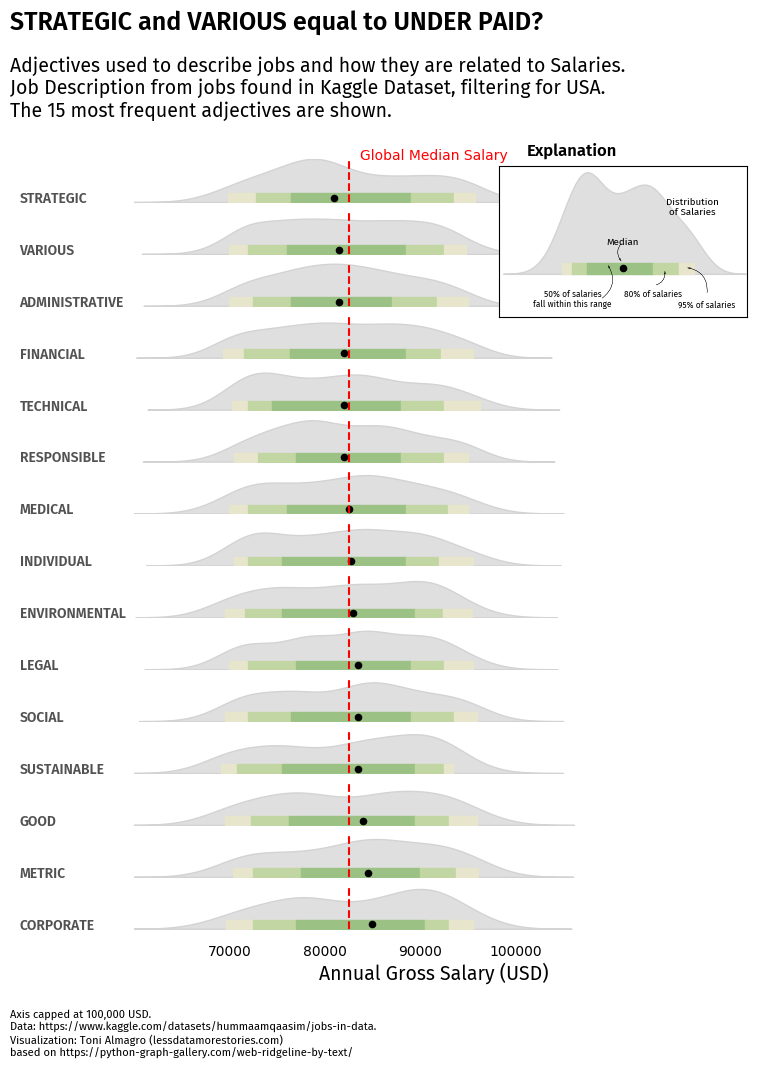

In [28]:
fig, axs = plt.subplots(nrows=15, ncols=1, figsize=(8, 10))
axs = axs.flatten()

variable = 'mean_salary'

darkgreen = '#9BC184'
midgreen = '#C2D6A4'
lowgreen = '#E7E5CB'
darkgrey = '#525252'

pos_avg_experience = 60_000
pos_words = 48_000
x_min, x_max = 60_000, 125_000

max_y = 0.00005
colors = [lowgreen,midgreen,darkgreen,midgreen,lowgreen]

for i, word in enumerate(words):

    subset = df2_adj[df2_adj['word']==word]
    
    sns.kdeplot(subset[variable], 
                fill=True,
                color = 'grey',
                edgecolor='lightgrey',
                ax=axs[i])
    
   
    """ 
    # display average number of bedrooms on left
    avg_experience = df_grouped[df_grouped['word']==word]['mean_experience'].values[0].round(1)
    axs[i].text(
        pos_avg_experience, 0,
        f'({avg_experience})',
        ha='left',
        fontsize=10,
        fontproperties=fira_sans_regular,
        color=darkgrey
    )
    """ 
    # display word on left
    axs[i].text(
        pos_words, 0,
        word.upper(),
        ha='left',
        fontsize=10,
        fontproperties=fira_sans_semibold,
        color=darkgrey
    )

    #quantiles
    quantiles = np.percentile(subset[variable], [2.5, 10,25,75,90,97.5])
    quantiles = quantiles.tolist()

    for j in range(len(quantiles)-1):
        axs[i].fill_between(
            [quantiles[j],
              quantiles[j+1]], 
                0,
                max_y/5,
                color = colors[j]
                )
        
    median = subset[variable].median()
    axs[i].scatter([median], [max_y/10], color='black', s=20)
            
    global_median = df[variable].median()
    axs[i].axvline(global_median, color='red', linestyle='--')

    axs[i].set_xlim(x_min, x_max)
    axs[i].set_ylim(0,max_y)
    axs[i].set_ylabel("")

    axs[i].set_axis_off()
    # x axis scale for last ax
    if i == 14:
        values = [70_000, 80_000, 90_000, 100_000]
        for value in values:
            axs[i].text(
                value, -0.00003,
                f'{value}',
                ha='center',
                fontsize=10
            )
        axs[i].set_xlabel('Salary')
        axs[i].set_xticks(values)

    
"""   
text = '(Avg. Experience)'
fig.text(
    0.06,
    0.88,
    text,
    ha='left',
    fontsize=10,
    fontproperties=fira_sans_regular,
    color=darkgrey
)
""" 
# x axis label
text = "Annual Gross Salary (USD)"
fig.text(
    0.5, 0.06,
    text,
    ha='center',
    fontsize=14,
    fontproperties=fira_sans_regular
)


text = 'Global Median Salary'
fig.text(0.5, 0.88, text,color='r', ha='center', fontsize=10)

# title
text = "STRATEGIC and VARIOUS equal to UNDER PAID?"
fig.text(
    -0.03, 1.01,
    text,
    ha='left',
    fontsize=18,
    fontproperties=fira_sans_semibold
)
text = """
Adjectives used to describe jobs and how they are related to Salaries.
Job Description from jobs found in Kaggle Dataset, filtering for USA.
The 15 most frequent adjectives are shown.
"""
fig.text(
    -0.03, 0.9,
    text,
    ha='left',
    fontsize=14,
    fontproperties=fira_sans_regular
)
# credit
text = """
Axis capped at 100,000 USD.
Data: https://www.kaggle.com/datasets/hummaamqaasim/jobs-in-data. 
Visualization: Toni Almagro (lessdatamorestories.com) 
based on https://python-graph-gallery.com/web-ridgeline-by-text/ 
"""
fig.text(
    -0.03, -0.03,
    text,
    ha='left',
    fontsize=8,
    fontproperties=fira_sans_regular
)

#Explanation
## ---------------

# legend on the first ax
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
subax = inset_axes(
    parent_axes=axs[0],
    width="40%",
    height="350%",
    loc=1
)
subax.set_xticks([])
subax.set_yticks([])
beautiful_subset = df2_adj[df2_adj['word']=='overall']

sns.kdeplot(
    beautiful_subset[variable],
    fill=True,
    ax=subax,
    color='grey',
    edgecolor='lightgrey'
)
quantiles = np.percentile(beautiful_subset[variable], [2.5, 10, 25, 75, 90, 97.5])
quantiles = quantiles.tolist()
for j in range(len(quantiles) - 1):
    subax.fill_between(
        [quantiles[j], # lower bound
         quantiles[j+1]], # upper bound
        0, # max y=0
        max_y/10, # max y=0.00004
        color=colors[j]
    )
subax.set_xlim(x_min, x_max-20_000)
subax.set_ylim(-0.00002, max_y)
mean = beautiful_subset[variable].median()
subax.scatter([mean], [0.0000025], color='black', s=20)

legend_pos = 0.000055
subax.text(
    x_min+5000, legend_pos,
    'Explanation',
    ha='left',
    fontsize=12,
    fontproperties=fira_sans_semibold
)

subax.text(
    x_max-30_000, legend_pos/2,
    'Distribution\nof Salaries',
    ha='center',
    fontsize=7,
    fontproperties=fira_sans_regular
)
subax.text(
    mean, legend_pos/4,
    'Median',
    ha='center',
    fontsize=7,
    fontproperties=fira_sans_regular
)

subtext_pos = -0.00001
subax.text(
    quantiles[4]+5_000,subtext_pos*1.5,
    "95% of salaries",
    ha='center',
    fontsize=6,
    fontproperties=fira_sans_regular
)

subax.text(
    quantiles[3],subtext_pos,
    "80% of salaries",
    ha='center',
    fontsize=6,
    fontproperties=fira_sans_regular
)
subax.text(
    quantiles[1], subtext_pos*1.5,
    "50% of salaries\nfall within this range",
    ha='center',
    fontsize=6,
    fontproperties=fira_sans_regular
)

# arrows in the legend
import matplotlib.patches as patches
def add_arrow(head_pos, tail_pos, ax):
    style = "Simple, tail_width=0.01, head_width=1, head_length=2"
    kw = dict(arrowstyle=style, color="k", linewidth=0.2)
    arrow = patches.FancyArrowPatch(
        tail_pos, head_pos,
        connectionstyle="arc3,rad=.5",
        **kw
    )
    ax.add_patch(arrow)
add_arrow( (mean-3_000, 0.000005),(quantiles[1]+5000, subtext_pos*1.2), subax) # 50%
add_arrow( (quantiles[3]+2000,0.0000025), (quantiles[3], -0.0000055),subax) # 80%
add_arrow((mean, 0.000005), (mean, 0.000015), subax) #,median 
add_arrow((quantiles[4]+1000, 0.000003), (quantiles[4]+5_000,subtext_pos), subax) # 50%

# background grey lines
from matplotlib.lines import Line2D
def add_line(xpos, ypos, fig=fig):
    line = Line2D(
        xpos, ypos,
        color='lightgrey',
        lw=0.2,
        transform=fig.transFigure
    )
    fig.lines.append(line)
#add_line([0.317, 0.317], [0.1, 0.9])
#add_line([0.51, 0.51], [0.1, 0.9])
#add_line([0.703, 0.703], [0.1, 0.9])
#add_line([0.896, 0.896], [0.1, 0.9])

plt.savefig('../images/jobs-ridgeline-by-text-USA.png', dpi=300, bbox_inches='tight')
plt.show()